In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import math
import numpy as np

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.layers import Dense, Input, Dropout, Activation, Conv2D, MaxPooling2D, Lambda, Flatten, GlobalAveragePooling2D
from keras.layers.merge import concatenate

from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
train_dir = 'data-ISBI/train/'
validation_dir = 'data-ISBI/validation/'
test_dir = 'data-ISBI/test/'
test_augmented_dir = 'data-ISBI/test-augmented/'

extracted_features_dir = "extracted_features/"
model_name = "VGG16_MobileNet_Concatenate_softmax"

In [5]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data-ISBI/train/ 0
data-ISBI/train/malignant 40424
data-ISBI/train/normal 18744
******************************
data-ISBI/test/ 0
data-ISBI/test/malignant 655
data-ISBI/test/normal 312


In [6]:
batch_size = 32
img_height, img_width = 450, 450
input_shape = (img_height, img_width, 3)
epochs = 1000

top_model_path = os.path.join(extracted_features_dir, 'model_'+model_name+'_model.h5')
top_model_weights_path = os.path.join(extracted_features_dir, 'model_'+model_name+'_weights.h5')

In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
#     validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
#     subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
#     subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

test_augmented_generator = test_datagen.flow_from_directory(
    test_augmented_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 59168 images belonging to 2 classes.
Found 18384 images belonging to 2 classes.
Found 967 images belonging to 2 classes.
Found 15472 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 59168
nb_validation_samples: 18384
nb_test_samples: 967

predict_size_train: 1849
predict_size_validation: 575
predict_size_test: 31

 num_classes: 2


In [9]:
basemodel1=VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
x1=basemodel1.get_layer('block5_pool').output
x1=GlobalAveragePooling2D()(x1)

basemodel2=MobileNet(weights=None,input_tensor = basemodel1.input, include_top=False, input_shape=input_shape)
x2 = basemodel2.output
x2 = GlobalAveragePooling2D()(x2)

merge = concatenate([x1, x2])
merge = Dropout(0.6)(merge)
preds = Dense(num_classes, activation='softmax')(merge)
model = Model(inputs=basemodel1.input,outputs=preds)

In [10]:
# bottleneck_final_model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

In [11]:
c1 = model.layers[74].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[80].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[88].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[96].output
c4 = GlobalAveragePooling2D()(c4)

c5 = model.layers[103].output
c5 = GlobalAveragePooling2D()(c5)


con = concatenate([c1,c2,c3,c4,c5])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [12]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [13]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [14]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [15]:
import tensorflow as tf
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

adam_opt=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.999, amsgrad=True)
model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

model.save_weights(top_model_weights_path)
model.save(top_model_path)

Train on 59168 samples, validate on 18384 samples
Epoch 1/1000
 - 8s - loss: 0.5418 - acc: 0.7407 - val_loss: 0.5032 - val_acc: 0.7750
Epoch 2/1000
 - 7s - loss: 0.4948 - acc: 0.7803 - val_loss: 0.4906 - val_acc: 0.7812
Epoch 3/1000
 - 7s - loss: 0.4861 - acc: 0.7832 - val_loss: 0.4859 - val_acc: 0.7837
Epoch 4/1000
 - 7s - loss: 0.4822 - acc: 0.7859 - val_loss: 0.4807 - val_acc: 0.7855
Epoch 5/1000
 - 7s - loss: 0.4783 - acc: 0.7870 - val_loss: 0.4819 - val_acc: 0.7852
Epoch 6/1000
 - 7s - loss: 0.4749 - acc: 0.7887 - val_loss: 0.4834 - val_acc: 0.7849
Epoch 7/1000
 - 7s - loss: 0.4724 - acc: 0.7903 - val_loss: 0.4733 - val_acc: 0.7909
Epoch 8/1000
 - 7s - loss: 0.4706 - acc: 0.7908 - val_loss: 0.4723 - val_acc: 0.7930
Epoch 9/1000
 - 7s - loss: 0.4672 - acc: 0.7928 - val_loss: 0.4757 - val_acc: 0.7894
Epoch 10/1000
 - 7s - loss: 0.4661 - acc: 0.7920 - val_loss: 0.4725 - val_acc: 0.7892
Epoch 11/1000
 - 7s - loss: 0.4634 - acc: 0.7942 - val_loss: 0.4681 - val_acc: 0.7966
Epoch 12/1000

Epoch 96/1000
 - 7s - loss: 0.4114 - acc: 0.8221 - val_loss: 0.4459 - val_acc: 0.8089
Epoch 97/1000
 - 7s - loss: 0.4103 - acc: 0.8199 - val_loss: 0.4312 - val_acc: 0.8170
Epoch 98/1000
 - 7s - loss: 0.4102 - acc: 0.8205 - val_loss: 0.4344 - val_acc: 0.8160
Epoch 99/1000
 - 7s - loss: 0.4092 - acc: 0.8229 - val_loss: 0.4334 - val_acc: 0.8165
Epoch 100/1000
 - 7s - loss: 0.4098 - acc: 0.8218 - val_loss: 0.4319 - val_acc: 0.8162
Epoch 101/1000
 - 7s - loss: 0.4098 - acc: 0.8210 - val_loss: 0.4306 - val_acc: 0.8172
Epoch 102/1000
 - 7s - loss: 0.4088 - acc: 0.8217 - val_loss: 0.4378 - val_acc: 0.8100
Epoch 103/1000
 - 7s - loss: 0.4088 - acc: 0.8215 - val_loss: 0.4348 - val_acc: 0.8149
Epoch 104/1000
 - 7s - loss: 0.4084 - acc: 0.8224 - val_loss: 0.4342 - val_acc: 0.8176
Epoch 105/1000
 - 7s - loss: 0.4077 - acc: 0.8223 - val_loss: 0.4300 - val_acc: 0.8177
Epoch 106/1000
 - 7s - loss: 0.4077 - acc: 0.8229 - val_loss: 0.4294 - val_acc: 0.8193
Epoch 107/1000
 - 7s - loss: 0.4076 - acc: 0.82

Epoch 191/1000
 - 7s - loss: 0.3888 - acc: 0.8322 - val_loss: 0.4231 - val_acc: 0.8215
Epoch 192/1000
 - 7s - loss: 0.3883 - acc: 0.8330 - val_loss: 0.4213 - val_acc: 0.8223
Epoch 193/1000
 - 7s - loss: 0.3891 - acc: 0.8325 - val_loss: 0.4255 - val_acc: 0.8171
Epoch 194/1000
 - 7s - loss: 0.3886 - acc: 0.8327 - val_loss: 0.4209 - val_acc: 0.8228
Epoch 195/1000
 - 7s - loss: 0.3881 - acc: 0.8332 - val_loss: 0.4215 - val_acc: 0.8235
Epoch 196/1000
 - 7s - loss: 0.3880 - acc: 0.8323 - val_loss: 0.4210 - val_acc: 0.8249
Epoch 197/1000
 - 7s - loss: 0.3879 - acc: 0.8330 - val_loss: 0.4199 - val_acc: 0.8221
Epoch 198/1000
 - 7s - loss: 0.3876 - acc: 0.8331 - val_loss: 0.4182 - val_acc: 0.8237
Epoch 199/1000
 - 7s - loss: 0.3877 - acc: 0.8322 - val_loss: 0.4199 - val_acc: 0.8232
Epoch 200/1000
 - 7s - loss: 0.3878 - acc: 0.8317 - val_loss: 0.4214 - val_acc: 0.8226
Epoch 201/1000
 - 7s - loss: 0.3881 - acc: 0.8319 - val_loss: 0.4201 - val_acc: 0.8222
Epoch 202/1000
 - 7s - loss: 0.3860 - acc: 

 - 7s - loss: 0.3724 - acc: 0.8406 - val_loss: 0.4158 - val_acc: 0.8249
Epoch 286/1000
 - 7s - loss: 0.3729 - acc: 0.8397 - val_loss: 0.4138 - val_acc: 0.8270
Epoch 287/1000
 - 7s - loss: 0.3724 - acc: 0.8397 - val_loss: 0.4176 - val_acc: 0.8227
Epoch 288/1000
 - 7s - loss: 0.3728 - acc: 0.8397 - val_loss: 0.4144 - val_acc: 0.8262
Epoch 289/1000
 - 7s - loss: 0.3712 - acc: 0.8403 - val_loss: 0.4141 - val_acc: 0.8280
Epoch 290/1000
 - 7s - loss: 0.3722 - acc: 0.8405 - val_loss: 0.4162 - val_acc: 0.8252
Epoch 291/1000
 - 7s - loss: 0.3714 - acc: 0.8408 - val_loss: 0.4152 - val_acc: 0.8263
Epoch 292/1000
 - 7s - loss: 0.3717 - acc: 0.8409 - val_loss: 0.4143 - val_acc: 0.8267
Epoch 293/1000
 - 7s - loss: 0.3709 - acc: 0.8417 - val_loss: 0.4141 - val_acc: 0.8266
Epoch 294/1000
 - 7s - loss: 0.3714 - acc: 0.8411 - val_loss: 0.4272 - val_acc: 0.8143
Epoch 295/1000
 - 7s - loss: 0.3708 - acc: 0.8408 - val_loss: 0.4152 - val_acc: 0.8267
Epoch 296/1000
 - 7s - loss: 0.3708 - acc: 0.8406 - val_lo

Epoch 380/1000
 - 7s - loss: 0.3581 - acc: 0.8457 - val_loss: 0.4172 - val_acc: 0.8263
Epoch 381/1000
 - 7s - loss: 0.3568 - acc: 0.8466 - val_loss: 0.4158 - val_acc: 0.8284
Epoch 382/1000
 - 7s - loss: 0.3569 - acc: 0.8472 - val_loss: 0.4147 - val_acc: 0.8237
Epoch 383/1000
 - 7s - loss: 0.3570 - acc: 0.8473 - val_loss: 0.4168 - val_acc: 0.8247
Epoch 384/1000
 - 7s - loss: 0.3563 - acc: 0.8463 - val_loss: 0.4143 - val_acc: 0.8270
Epoch 385/1000
 - 7s - loss: 0.3572 - acc: 0.8471 - val_loss: 0.4142 - val_acc: 0.8266
Epoch 386/1000
 - 7s - loss: 0.3567 - acc: 0.8462 - val_loss: 0.4289 - val_acc: 0.8214
Epoch 387/1000
 - 7s - loss: 0.3572 - acc: 0.8460 - val_loss: 0.4134 - val_acc: 0.8285
Epoch 388/1000
 - 7s - loss: 0.3568 - acc: 0.8464 - val_loss: 0.4186 - val_acc: 0.8248
Epoch 389/1000
 - 7s - loss: 0.3556 - acc: 0.8473 - val_loss: 0.4180 - val_acc: 0.8223
Epoch 390/1000
 - 7s - loss: 0.3559 - acc: 0.8472 - val_loss: 0.4132 - val_acc: 0.8290
Epoch 391/1000
 - 7s - loss: 0.3551 - acc: 

 - 7s - loss: 0.3432 - acc: 0.8526 - val_loss: 0.4109 - val_acc: 0.8292
Epoch 475/1000
 - 7s - loss: 0.3422 - acc: 0.8522 - val_loss: 0.4128 - val_acc: 0.8294
Epoch 476/1000
 - 7s - loss: 0.3429 - acc: 0.8541 - val_loss: 0.4116 - val_acc: 0.8283
Epoch 477/1000
 - 7s - loss: 0.3427 - acc: 0.8531 - val_loss: 0.4115 - val_acc: 0.8312
Epoch 478/1000
 - 7s - loss: 0.3422 - acc: 0.8550 - val_loss: 0.4141 - val_acc: 0.8293
Epoch 479/1000
 - 7s - loss: 0.3430 - acc: 0.8525 - val_loss: 0.4118 - val_acc: 0.8267
Epoch 480/1000
 - 7s - loss: 0.3433 - acc: 0.8530 - val_loss: 0.4154 - val_acc: 0.8244
Epoch 481/1000
 - 7s - loss: 0.3425 - acc: 0.8545 - val_loss: 0.4117 - val_acc: 0.8315
Epoch 482/1000
 - 7s - loss: 0.3418 - acc: 0.8536 - val_loss: 0.4225 - val_acc: 0.8197
Epoch 483/1000
 - 7s - loss: 0.3419 - acc: 0.8547 - val_loss: 0.4108 - val_acc: 0.8305
Epoch 484/1000
 - 7s - loss: 0.3410 - acc: 0.8536 - val_loss: 0.4133 - val_acc: 0.8274
Epoch 485/1000
 - 7s - loss: 0.3412 - acc: 0.8538 - val_lo

Epoch 569/1000
 - 7s - loss: 0.3305 - acc: 0.8588 - val_loss: 0.4197 - val_acc: 0.8230
Epoch 570/1000
 - 7s - loss: 0.3290 - acc: 0.8599 - val_loss: 0.4255 - val_acc: 0.8267
Epoch 571/1000
 - 7s - loss: 0.3281 - acc: 0.8589 - val_loss: 0.4137 - val_acc: 0.8289
Epoch 572/1000
 - 7s - loss: 0.3299 - acc: 0.8582 - val_loss: 0.4129 - val_acc: 0.8309
Epoch 573/1000
 - 7s - loss: 0.3286 - acc: 0.8602 - val_loss: 0.4124 - val_acc: 0.8325
Epoch 574/1000
 - 7s - loss: 0.3294 - acc: 0.8586 - val_loss: 0.4198 - val_acc: 0.8293
Epoch 575/1000
 - 7s - loss: 0.3297 - acc: 0.8576 - val_loss: 0.4142 - val_acc: 0.8302
Epoch 576/1000
 - 7s - loss: 0.3282 - acc: 0.8596 - val_loss: 0.4095 - val_acc: 0.8299
Epoch 577/1000
 - 7s - loss: 0.3283 - acc: 0.8604 - val_loss: 0.4134 - val_acc: 0.8336
Epoch 578/1000
 - 7s - loss: 0.3287 - acc: 0.8602 - val_loss: 0.4119 - val_acc: 0.8296
Epoch 579/1000
 - 7s - loss: 0.3283 - acc: 0.8605 - val_loss: 0.4162 - val_acc: 0.8296
Epoch 580/1000
 - 7s - loss: 0.3267 - acc: 

 - 7s - loss: 0.3165 - acc: 0.8640 - val_loss: 0.4230 - val_acc: 0.8239
Epoch 664/1000
 - 7s - loss: 0.3185 - acc: 0.8640 - val_loss: 0.4161 - val_acc: 0.8331
Epoch 665/1000
 - 7s - loss: 0.3165 - acc: 0.8647 - val_loss: 0.4357 - val_acc: 0.8165
Epoch 666/1000
 - 7s - loss: 0.3157 - acc: 0.8647 - val_loss: 0.4138 - val_acc: 0.8310
Epoch 667/1000
 - 7s - loss: 0.3154 - acc: 0.8652 - val_loss: 0.4176 - val_acc: 0.8280
Epoch 668/1000
 - 7s - loss: 0.3147 - acc: 0.8655 - val_loss: 0.4133 - val_acc: 0.8303
Epoch 669/1000
 - 7s - loss: 0.3162 - acc: 0.8646 - val_loss: 0.4104 - val_acc: 0.8327
Epoch 670/1000
 - 7s - loss: 0.3155 - acc: 0.8649 - val_loss: 0.4117 - val_acc: 0.8299
Epoch 671/1000
 - 7s - loss: 0.3158 - acc: 0.8652 - val_loss: 0.4151 - val_acc: 0.8309
Epoch 672/1000
 - 7s - loss: 0.3149 - acc: 0.8652 - val_loss: 0.4105 - val_acc: 0.8320
Epoch 673/1000
 - 7s - loss: 0.3135 - acc: 0.8664 - val_loss: 0.4136 - val_acc: 0.8310
Epoch 674/1000
 - 7s - loss: 0.3160 - acc: 0.8651 - val_lo

Epoch 758/1000
 - 7s - loss: 0.3041 - acc: 0.8711 - val_loss: 0.4138 - val_acc: 0.8333
Epoch 759/1000
 - 7s - loss: 0.3028 - acc: 0.8712 - val_loss: 0.4140 - val_acc: 0.8304
Epoch 760/1000
 - 7s - loss: 0.3034 - acc: 0.8706 - val_loss: 0.4197 - val_acc: 0.8332
Epoch 761/1000
 - 7s - loss: 0.3013 - acc: 0.8722 - val_loss: 0.4169 - val_acc: 0.8326
Epoch 762/1000
 - 7s - loss: 0.3025 - acc: 0.8701 - val_loss: 0.4136 - val_acc: 0.8337
Epoch 763/1000
 - 7s - loss: 0.3017 - acc: 0.8714 - val_loss: 0.4171 - val_acc: 0.8307
Epoch 764/1000
 - 7s - loss: 0.3016 - acc: 0.8715 - val_loss: 0.4182 - val_acc: 0.8331
Epoch 765/1000
 - 7s - loss: 0.3025 - acc: 0.8714 - val_loss: 0.4264 - val_acc: 0.8299
Epoch 766/1000
 - 7s - loss: 0.3010 - acc: 0.8718 - val_loss: 0.4134 - val_acc: 0.8344
Epoch 767/1000
 - 7s - loss: 0.3023 - acc: 0.8706 - val_loss: 0.4198 - val_acc: 0.8315
Epoch 768/1000
 - 7s - loss: 0.3025 - acc: 0.8706 - val_loss: 0.4195 - val_acc: 0.8270
Epoch 769/1000
 - 7s - loss: 0.3028 - acc: 

 - 7s - loss: 0.2931 - acc: 0.8765 - val_loss: 0.4174 - val_acc: 0.8346
Epoch 853/1000
 - 7s - loss: 0.2899 - acc: 0.8773 - val_loss: 0.4161 - val_acc: 0.8333
Epoch 854/1000
 - 7s - loss: 0.2907 - acc: 0.8767 - val_loss: 0.4144 - val_acc: 0.8340
Epoch 855/1000
 - 7s - loss: 0.2913 - acc: 0.8759 - val_loss: 0.4194 - val_acc: 0.8321
Epoch 856/1000
 - 7s - loss: 0.2924 - acc: 0.8759 - val_loss: 0.4158 - val_acc: 0.8372
Epoch 857/1000
 - 7s - loss: 0.2908 - acc: 0.8774 - val_loss: 0.4254 - val_acc: 0.8327
Epoch 858/1000
 - 7s - loss: 0.2903 - acc: 0.8776 - val_loss: 0.4209 - val_acc: 0.8314
Epoch 859/1000
 - 7s - loss: 0.2890 - acc: 0.8784 - val_loss: 0.4262 - val_acc: 0.8350
Epoch 860/1000
 - 7s - loss: 0.2908 - acc: 0.8770 - val_loss: 0.4161 - val_acc: 0.8341
Epoch 861/1000
 - 7s - loss: 0.2902 - acc: 0.8789 - val_loss: 0.4251 - val_acc: 0.8326
Epoch 862/1000
 - 7s - loss: 0.2903 - acc: 0.8781 - val_loss: 0.4155 - val_acc: 0.8351
Epoch 863/1000
 - 7s - loss: 0.2916 - acc: 0.8757 - val_lo

Epoch 947/1000
 - 7s - loss: 0.2804 - acc: 0.8811 - val_loss: 0.4262 - val_acc: 0.8284
Epoch 948/1000
 - 7s - loss: 0.2794 - acc: 0.8809 - val_loss: 0.4233 - val_acc: 0.8312
Epoch 949/1000
 - 7s - loss: 0.2812 - acc: 0.8805 - val_loss: 0.4187 - val_acc: 0.8306
Epoch 950/1000
 - 7s - loss: 0.2796 - acc: 0.8821 - val_loss: 0.4205 - val_acc: 0.8304
Epoch 951/1000
 - 7s - loss: 0.2795 - acc: 0.8825 - val_loss: 0.4216 - val_acc: 0.8339
Epoch 952/1000
 - 7s - loss: 0.2791 - acc: 0.8817 - val_loss: 0.4247 - val_acc: 0.8301
Epoch 953/1000
 - 7s - loss: 0.2780 - acc: 0.8825 - val_loss: 0.4266 - val_acc: 0.8340
Epoch 954/1000
 - 7s - loss: 0.2785 - acc: 0.8826 - val_loss: 0.4273 - val_acc: 0.8295
Epoch 955/1000
 - 7s - loss: 0.2793 - acc: 0.8828 - val_loss: 0.4374 - val_acc: 0.8285
Epoch 956/1000
 - 7s - loss: 0.2775 - acc: 0.8833 - val_loss: 0.4306 - val_acc: 0.8316
Epoch 957/1000
 - 7s - loss: 0.2799 - acc: 0.8828 - val_loss: 0.4230 - val_acc: 0.8348
Epoch 958/1000
 - 7s - loss: 0.2784 - acc: 

In [18]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

18384/18384 [==============================] - 1s 42us/step
Validation Accuracy: 83.2789%
Validation Loss: 0.4221349125120098


In [19]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8521199586349535


Confusion Matrix
[[622  33]
 [110 202]]


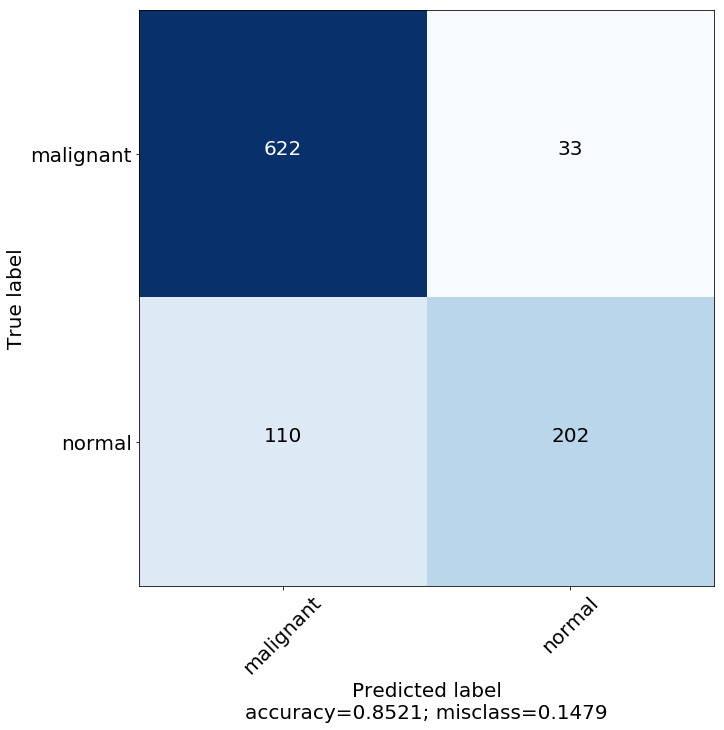

In [21]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[622  33]
 [110 202]]
              precision    recall  f1-score   support

      normal       0.85      0.95      0.90       655
   malignant       0.86      0.65      0.74       312

   micro avg       0.85      0.85      0.85       967
   macro avg       0.85      0.80      0.82       967
weighted avg       0.85      0.85      0.85       967



In [23]:
total=sum(sum(cm))

# accuracy = (cm[0,0]+cm[1,1]) / total
# print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  84.97267759562843
Specificity :  85.95744680851064


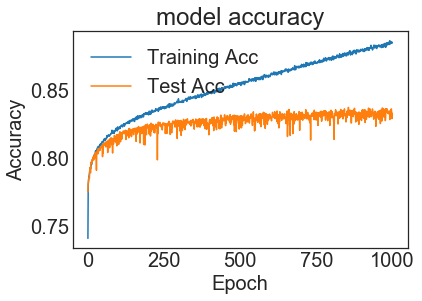

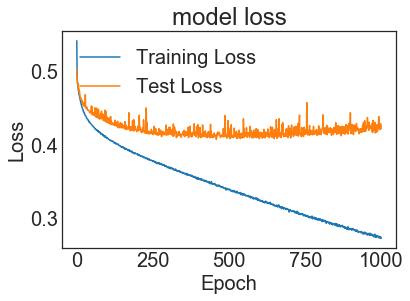

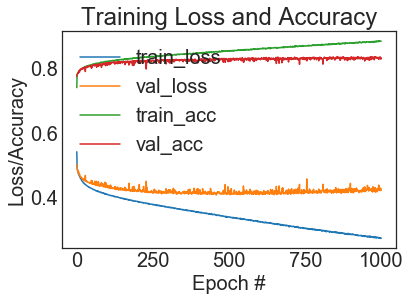

In [24]:
import seaborn
plt.style.use('seaborn-white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [25]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

967/967 [==============================] - 0s 51us/step
Precision =  0.8529041078530707
Recall =  0.8521199586349535
f1_score =  0.8458164000783571


In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.7985271090232922


In [28]:
sample_count = test_generator.samples
print('Sample count: {}'.format(sample_count))

Sample count: 967


In [29]:
fnames = test_generator.filenames
ground_truth = test_generator.classes
label2index = test_generator.class_indices
# Getting the mapping from class index to class label
idx2label = dict((v, k) for k, v in label2index.items())
predictions = model.predict_classes(test_data)
prob = model.predict(test_data)
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), sample_count))

No of errors = 143/967


In [ ]:
from keras.preprocessing.image import load_img, img_to_array, array_to_img

fnames = test_generator.filenames
label2index = test_generator.class_indices
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())


errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}, class ID : {}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        prob[errors[i]][pred_class], pred_class)
    
    original = load_img('{}/{}'.format(test_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
plt.show()

In [37]:
len(errors)

143

In [40]:
for i in range(len(errors)):
        print(fnames[errors[i]])

malignant\UID_11_15_2_all.jpg
malignant\UID_14_5_3_all.jpg
malignant\UID_16_3_2_all.jpg
malignant\UID_1_9_1_all.jpg
malignant\UID_22_35_1_all.jpg
malignant\UID_23_10_2_all.jpg
malignant\UID_23_17_1_all.jpg
malignant\UID_25_14_2_all.jpg
malignant\UID_25_8_5_all.jpg
malignant\UID_26_5_4_all.jpg
malignant\UID_26_5_5_all.jpg
malignant\UID_27_14_2_all.jpg
malignant\UID_27_1_8_all.jpg
malignant\UID_2_15_1_all.jpg
malignant\UID_30_23_5_all.jpg
malignant\UID_31_5_4_all.jpg
malignant\UID_33_30_2_all.jpg
malignant\UID_36_1_1_all.jpg
malignant\UID_37_25_12_all.jpg
malignant\UID_38_22_11_all.jpg
malignant\UID_43_12_2_all.jpg
malignant\UID_43_7_5_all.jpg
malignant\UID_44_1_5_all.jpg
malignant\UID_44_34_2_all.jpg
malignant\UID_45_3_3_all.jpg
malignant\UID_47_4_3_all.jpg
malignant\UID_48_11_10_all.jpg
malignant\UID_49_35_2_all.jpg
malignant\UID_50_28_8_all.jpg
malignant\UID_51_12_2_all.jpg
malignant\UID_52_16_10_all.jpg
malignant\UID_5_29_3_all.jpg
malignant\UID_67_32_2_all.jpg
normal\UID_H10_102_5_h